## GPU

Enable GPU with `Runtime->Change runtime type->Hardware Accelerator->GPU` in the top menu

In [1]:
# imports and stuff
import time
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
import rasterio
import gdal
import scipy
import cv2


from semanticsegmentation.models.unet import *
from semanticsegmentation.models import *
from semanticsegmentation.models.backbones import MiT
from semanticsegmentation.models.segformer import SegFormer

/home/pagraf/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
import sys

# data are assumed to be in Vaihingen/ directory, otherwise modify accordingly
FOLDER = '/home/pagraf/Desktop/magicbathy/'
sys.path.append(FOLDER)

# Parameters

In [3]:
# Parameters++++

#dataset = "S2_AgiaNapa"
#dataset = "SPOT6_AgiaNapa"
dataset = "UAV_AgiaNapa"

#area = "puck_laggon"
area = "agia_napa"

if dataset == "UAV_AgiaNapa":
    norm_param = 255
    WINDOW_SIZE = (704, 704) #704, 704
    STRIDE = 32
    BATCH_SIZE = 4
    MAIN_FOLDER = FOLDER
    train_images = ['409', '418', '350', '399', '361', '430', '380', '359', '371', '377', '379', '360', '368', '419', '389', '420', '401', '408', '352', '388', '362', '421', '412', '351', '349', '390', '400', '378']
    test_images = ['411', '387', '410', '398', '370', '369', '397']
    #nlcd02_arr_1, nlcd02_ds_1 = read_geotiff(MAIN_FOLDER + 'img_uav.tif', 3)
    if WINDOW_SIZE[0] < 128:
        scale = 128/WINDOW_SIZE[0]
        test_window = 128
    else:
        scale = 1
        test_window = WINDOW_SIZE[0]
    inv_scale = 1/scale
elif dataset == "SPOT6_AgiaNapa":
    norm_param = 1300 #2500 agia
    WINDOW_SIZE = (30, 30)
    STRIDE = 2
    BATCH_SIZE = 4
    MAIN_FOLDER = FOLDER 
    train_images = ['191', '851', '3213', '2866', '2964', '2770', '2871', '2626', '1127', '2400', '1287', '2419', '741', '924', '0', '2926', '3267', '2772', '736', '3161', '638', '3173', '2181', '792', '613', '2985', '1031', '2768', '3214', '2827', '2950', '541', '246', '3179', '739', '2672', '2107', '1120', '3052', '1215', '815', '1270', '3136', '2746', '3253', '921', '3066', '2042', '1107', '235', '2719', '1302', '2867', '440', '1465', '2824', '2715', '1', '1029', '448', '2031', '1460', '608', '2841', '2929', '1383', '2949', '192', '3287', '1070', '3298', '2951', '2680', '1162', '3233', '2248', '1397', '2677', '334', '2119', '735', '3303', '2607', '1463', '2678', '1292', '2420', '1020', '1871', '586', '3281', '809', '2948', '2571', '2718', '2825', '983', '2197', '1379', '2486', '2465', '2643', '1985', '491', '657', '2889', '3081', '831', '1547', '2983', '3156', '2555', '2720', '2401', '2493', '2204', '2618', '2730', '824', '1197', '677', '703', '1793', '2662', '5', '1458', '446', '3248', '1401', '1200', '2716', '2040', '2968', '2544', '897', '3309', '3095', '3252', '971', '900', '3290', '2908', '812', '894', '384', '3235', '691', '3109', '771', '3251', '3050', '804', '1211', '3310', '2588', '3171', '49', '2869', '2679', '2193', '1979', '2492', '2911', '936', '1073', '3067', '822', '1214', '1010', '3181', '1882', '3280', '774', '928', '3197', '9', '1118', '2545', '844', '896', '2572', '1468', '441', '3084', '3155', '980', '3035', '3277', '3199', '1461', '1069', '1023', '102', '1008', '918', '2143', '3163', '3250', '2274', '2872', '861', '661', '1022', '94', '2606', '970', '1407', '1382', '1370', '2333', '1880', '725', '3083', '2947', '716', '3134', '3164', '742', '2845', '598', '2616', '510', '2249', '2173', '1956', '3079', '2829', '2548', '718', '836', '3024', '3177', '1408', '2201', '96', '1381', '2665', '195', '823', '493', '588', '663', '2334', '2669', '2609', '2331', '3279', '743', '760', '2104', '1293', '100', '455', '2045', '2723', '420', '2627', '3124', '1318', '2888', '3002', '1038', '2129', '2174', '1632', '738', '2722', '3113', '3138', '53', '3193', '1018', '3286', '2408', '1707', '3305', '639', '2965', '48', '2172', '1025', '2724', '2471', '3219', '2046', '3221', '2915', '642', '599', '1356', '604', '853', '2674', '6', '3268', '2660', '920', '1377', '3054', '727', '1220', '3291', '3130', '1630', '3265', '1790', '1548', '2346', '914', '3237', '3198', '3020', '2530', '43', '3080', '95', '2644', '3135', '294', '2670', '2179', '614', '2696', '3278', '54', '1455', '852', '2727', '827', '1269', '3137', '3183', '2528', '1119', '702', '2930', '3003', '2629', '2472', '675', '2795', '1219', '3232', '2531', '2873', '2868', '3132', '1322', '1982', '390', '290', '542', '2428', '676', '3112', '1355', '3149', '2781', '339', '392', '734', '50', '3023', '3096', '1551', '2340', '2822', '728', '3122', '1125', '558', '3200', '840', '3282', '1071', '1011', '46', '2142', '2180', '1643', '1285', '2729', '2780', '556', '3266', '435', '2988', '1372', '1111', '1072', '3263', '1538', '829', '1373', '1357', '2175', '1099', '2035'] 
    test_images = ['2271', '2797', '3018', '2260', '2558', '3216', '929', '3269', '1464', '2125', '1454', '814', '2928', '283', '689', '47', '3236', '1012', '1208', '97', '1017', '3276', '3082', '4', '1160', '143', '447', '1300', '2846', '919', '1110', '289', '2529', '2748', '142', '352', '2615', '830', '1466', '1542', '2987', '1488', '2409', '2468', '2909', '1117', '389', '1625', '1951', '391', '615', '560', '912', '1109', '922', '93', '59', '1286', '1013', '825', '2178', '2126', '3001', '737', '3238', '2910', '2890', '1384', '730', '3154', '2982', '520', '3202', '3231', '3160', '1039', '2117', '2427', '2247', '2403', '916', '471', '923', '1291', '489', '3123', '2350', '2773', '2843', '2956', '962', '1213', '761', '2194', '759', '2108', '927', '2697', '537', '3051']
    #nlcd02_arr_1, nlcd02_ds_1 = read_geotiff(MAIN_FOLDER + 'img_spot6.tif', 3)
    if WINDOW_SIZE[0] < 256:
        scale = 256/WINDOW_SIZE[0]
        test_window = 256
    else:
        scale = 1
        test_window = WINDOW_SIZE[0]
    inv_scale = 1/scale
elif dataset == "S2_AgiaNapa":
    norm_param = 2200 #2529 agia napa was 16000 in puck to get better results in 3051
    WINDOW_SIZE = (18, 18)
    STRIDE = 2
    BATCH_SIZE = 4
    MAIN_FOLDER = FOLDER 
    train_images = ['191', '851', '3213', '2866', '2964', '2770', '2871', '2626', '1127', '2400', '1287', '2419', '741', '924', '0', '2926', '3267', '2772', '736', '3161', '638', '3173', '2181', '792', '613', '2985', '1031', '2768', '3214', '2827', '2950', '541', '246', '3179', '739', '2672', '2107', '1120', '3052', '1215', '815', '1270', '3136', '2746', '3253', '921', '3066', '2042', '1107', '235', '2719', '1302', '2867', '440', '1465', '2824', '2715', '1', '1029', '448', '2031', '1460', '608', '2841', '2929', '1383', '2949', '192', '3287', '1070', '3298', '2951', '2680', '1162', '3233', '2248', '1397', '2677', '334', '2119', '735', '3303', '2607', '1463', '2678', '1292', '2420', '1020', '1871', '586', '3281', '809', '2948', '2571', '2718', '2825', '983', '2197', '1379', '2486', '2465', '2643', '1985', '491', '657', '2889', '3081', '831', '1547', '2983', '3156', '2555', '2720', '2401', '2493', '2204', '2618', '2730', '824', '1197', '677', '703', '1793', '2662', '5', '1458', '446', '3248', '1401', '1200', '2716', '2040', '2968', '2544', '897', '3309', '3095', '3252', '971', '900', '3290', '2908', '812', '894', '384', '3235', '691', '3109', '771', '3251', '3050', '804', '1211', '3310', '2588', '3171', '49', '2869', '2679', '2193', '1979', '2492', '2911', '936', '1073', '3067', '822', '1214', '1010', '3181', '1882', '3280', '774', '928', '3197', '9', '1118', '2545', '844', '896', '2572', '1468', '441', '3084', '3155', '980', '3035', '3277', '3199', '1461', '1069', '1023', '102', '1008', '918', '2143', '3163', '3250', '2274', '2872', '861', '661', '1022', '94', '2606', '970', '1407', '1382', '1370', '2333', '1880', '725', '3083', '2947', '716', '3134', '3164', '742', '2845', '598', '2616', '510', '2249', '2173', '1956', '3079', '2829', '2548', '718', '836', '3024', '3177', '1408', '2201', '96', '1381', '2665', '195', '823', '493', '588', '663', '2334', '2669', '2609', '2331', '3279', '743', '760', '2104', '1293', '100', '455', '2045', '2723', '420', '2627', '3124', '1318', '2888', '3002', '1038', '2129', '2174', '1632', '738', '2722', '3113', '3138', '53', '3193', '1018', '3286', '2408', '1707', '3305', '639', '2965', '48', '2172', '1025', '2724', '2471', '3219', '2046', '3221', '2915', '642', '599', '1356', '604', '853', '2674', '6', '3268', '2660', '920', '1377', '3054', '727', '1220', '3291', '3130', '1630', '3265', '1790', '1548', '2346', '914', '3237', '3198', '3020', '2530', '43', '3080', '95', '2644', '3135', '294', '2670', '2179', '614', '2696', '3278', '54', '1455', '852', '2727', '827', '1269', '3137', '3183', '2528', '1119', '702', '2930', '3003', '2629', '2472', '675', '2795', '1219', '3232', '2531', '2873', '2868', '3132', '1322', '1982', '390', '290', '542', '2428', '676', '3112', '1355', '3149', '2781', '339', '392', '734', '50', '3023', '3096', '1551', '2340', '2822', '728', '3122', '1125', '558', '3200', '840', '3282', '1071', '1011', '46', '2142', '2180', '1643', '1285', '2729', '2780', '556', '3266', '435', '2988', '1372', '1111', '1072', '3263', '1538', '829', '1373', '1357', '2175', '1099', '2035'] 
    test_images = ['2271', '2797', '3018', '2260', '2558', '3216', '929', '3269', '1464', '2125', '1454', '814', '2928', '283', '689', '47', '3236', '1012', '1208', '97', '1017', '3276', '3082', '4', '1160', '143', '447', '1300', '2846', '919', '1110', '289', '2529', '2748', '142', '352', '2615', '830', '1466', '1542', '2987', '1488', '2409', '2468', '2909', '1117', '389', '1625', '1951', '391', '615', '560', '912', '1109', '922', '93', '59', '1286', '1013', '825', '2178', '2126', '3001', '737', '3238', '2910', '2890', '1384', '730', '3154', '2982', '520', '3202', '3231', '3160', '1039', '2117', '2427', '2247', '2403', '916', '471', '923', '1291', '489', '3123', '2350', '2773', '2843', '2956', '962', '1213', '761', '2194', '759', '2108', '927', '2697', '537', '3051']
    #nlcd02_arr_1, nlcd02_ds_1 = read_geotiff(MAIN_FOLDER + 'img_s2.tif', 3)
    if WINDOW_SIZE[0] < 256:
        scale = 256/WINDOW_SIZE[0]
        test_window = 256
    else:
        scale = 1
        test_window = WINDOW_SIZE[0]
    inv_scale = 1/scale

print(norm_param)

if area == "agia_napa":
    #net = SegFormer('MiT-B5', 5)
    net = UNet(3, 5)
    LABELS = ["poseidonia", "rock", "macroalgae", "sand", "ignored"] # Label names
    N_CLASSES = len(LABELS) # Number of classes
    print(N_CLASSES)
    WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
    l =1.
    WEIGHTS[4] = 0.
    WEIGHTS[0] = l
    WEIGHTS[1] = l
    WEIGHTS[2] = l
    WEIGHTS[3] = l
    print(WEIGHTS)

if area == "puck_lagoon":
    #net = SegFormer('MiT-B5', 3)
    net = UNet(3, 3)
    LABELS = ["sand", "poseidonia", "ignored"] # Label names
    N_CLASSES = len(LABELS) # Number of classes
    print(N_CLASSES)
    WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
    l =1.
    WEIGHTS[0] = l
    WEIGHTS[1] = l
    WEIGHTS[2] = 0

print(WEIGHTS)


base_lr = 0.00001


CACHE = False # Store the dataset in-memory



DATA_FOLDER = MAIN_FOLDER + 'agia_napa/img/aerial/img_{}.tif'
LABEL_FOLDER = MAIN_FOLDER + 'agia_napa/gts/aerial/gts_{}.tif'
ERODED_FOLDER = MAIN_FOLDER + 'agia_napa/gts/aerial/gts_{}.tif'
   
    


255
5
tensor([1., 1., 1., 1., 0.])
tensor([1., 1., 1., 1., 0.])



# Visualizing the dataset

First, let's check that we are able to access the dataset and see what's going on. We use scikit-image for image manipulation.

As the ISPRS dataset is stored with a ground truth in the RGB format, we need to define the color palette that can map the label id to its RGB color. We define two helper functions to convert from numeric to colors and vice-versa.


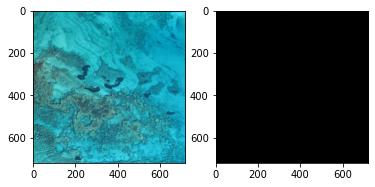

Ground truth in numerical format has shape (720,720) : 
 [[4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 ...
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]]


In [4]:
# color palette

if area == "agia_napa":
    palette = {0 : (102, 102, 102), #poseidonia
               1 : (255, 255, 255), #rock
               2 : (159, 159, 159), #macroalgae
               3 : (63, 63, 63),    #sand
               4 : (0, 0, 0)}       #Undefined (black)

if area == "puck_lagoon":
    palette = {0 : (157, 157, 157), #poseidonia
               1 : (255, 255, 255), #rock
               2 : (0, 0, 0)}       #Undefined (black)


invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

# We load one tile from the dataset and we display it
img = io.imread(MAIN_FOLDER+'agia_napa/img/aerial/img_409.tif')
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(img[:, :, :]/norm_param)

# We load the ground truth
gt = io.imread(MAIN_FOLDER+'agia_napa/gts/aerial/gts_409.tif')
fig.add_subplot(122)
plt.imshow(gt)
plt.show()

# We also check that we can convert the ground truth into an array format
array_gt = convert_from_color(gt)
print("Ground truth in numerical format has shape ({},{}) : \n".format(*array_gt.shape[:2]), array_gt)




We need to define a bunch of utils functions.

In [5]:
# Utils

def get_random_pos(img, window_shape):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 0)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 0)
    y2 = y1 + h
    return x1, x2, y1, y2

def CrossEntropy2d(input, target, weight=None, reduction=True):
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, reduction='mean')
##        return nn.CrossEntropyLoss(output, target,weight)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target,weight, reduction='mean')
##        return nn.CrossEntropyLoss(output, target,weight)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

#def accuracy(input, target):
#    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def metrics(predictions, gts, label_values=["poseidonia", "rock", "macroalgae", "sand"]):
    cm = confusion_matrix(
            gts,
            predictions)
    
    cols_rows_to_use = N_CLASSES-1
    cm = cm[:cols_rows_to_use,:cols_rows_to_use]
    
    print("Confusion matrix :")
    print(cm)
    
    print("---")
    
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])

    accuracy *= 100 / (float(total)+0.00000000000000000000000000000000000000000000000001)


    #accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    
    print("---")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")
        
    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    return accuracy


def metrics_2(predictions, gts, label_values=["poseidonia", "rock", "macroalgae", "sand"]):
    cm = confusion_matrix(
            gts,
            predictions)
    
    cols_rows_to_use = N_CLASSES-1
    cm = cm[:cols_rows_to_use,:cols_rows_to_use]
       
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    
    accuracy *= 100 / (float(total)+0.00000000000000000000000000000000000000000000000001)

    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    
    return accuracy

def read_geotiff(filename, b):
    ds = gdal.Open(filename)
    band = ds.GetRasterBand(b)
    arr = band.ReadAsArray()
    return arr, ds

def write_geotiff(filename, arr, in_ds):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr)
    band.FlushCache()
    band.ComputeStatistics(False)


# Loading the dataset

We define a PyTorch dataset (`torch.utils.data.Dataset)` that loads all the tiles in memory and performs random sampling. Tiles are stored in memory on the fly.

The dataset also performs random data augmentation (horizontal and vertical flips) and normalizes the data in [0, 1].

In [6]:
# Dataset class
import cv2
from torchvision.transforms import Resize

random.seed(1)
        
class ISPRS_dataset(torch.utils.data.Dataset):
    def __init__(self, ids, data_files=DATA_FOLDER, label_files=LABEL_FOLDER,
                            cache=False, augmentation=True):
        super(ISPRS_dataset, self).__init__()
        
        self.augmentation = augmentation
        self.cache = cache
        
        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in ids]
        
        

        # Sanity check : raise an error if some files do not exist
        for f in self.data_files + self.label_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))
        
        # Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}
            
    
    def __len__(self):
        # Default epoch size is 10 000 samples
        return 10000
    
    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True
        
        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))
            
        return tuple(results)
    
    def __getitem__(self, i):
        
        # Pick a random image
        
        random_idx = random.randint(0, len(self.data_files) - 1)
        
        
        # If the tile hasn't been loaded yet, put in cache
        if random_idx in self.data_cache_.keys():
            data = self.data_cache_[random_idx]
        else:
            # Data is normalized in [0, 1]
            data = 1/norm_param * np.asarray(io.imread(self.data_files[random_idx]).transpose((2,0,1)), dtype='float32')
            if self.cache:
                self.data_cache_[random_idx] = data
            
        if random_idx in self.label_cache_.keys():
            label = self.label_cache_[random_idx]
        else: 
            # Labels are converted from RGB to their numeric values
            label = np.asarray(convert_from_color(io.imread(self.label_files[random_idx])), dtype='int64')
            if self.cache:
                self.label_cache_[random_idx] = label
        
        if dataset == "UAV_AgiaNapa":
            data[data == 0] = 0.5
        if dataset == "SPOT6_AgiaNapa":
            data[data == 0] = 0.5
        
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
                                    #to be fixed, only for spot6
        label_p = label[x1:x2,y1:y2]


        

        data_p, label_p = self.data_augmentation(data_p, label_p)
        
        if np.mean(label_p) < 4:
            label_p = label_p
            data_p = data_p
        else:
            x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
            data_p = data[:, x1:x2,y1:y2]
            label_p = label[x1:x2,y1:y2]

            data_p, label_p = self.data_augmentation(data_p, label_p)
        '''
        def pad_with(vector, pad_width, iaxis, kwargs):
            pad_value = kwargs.get('padder', 10)
            vector[:pad_width[0]] = pad_value
            vector[-pad_width[1]:] = pad_value
        
        print(data_p.shape)
            
        data_p = np.pad(data_p, pad_width=[(0, 0),(56, 56),(56, 56)], mode='constant')
        label_p = np.pad(label_p, pad_width=[(56, 56),(56, 56)], mode='constant')
            
        print(data_p.shape) 
        '''
   
        data_p = scipy.ndimage.zoom(data_p, (1,scale,scale), order=0)
        label_p = scipy.ndimage.zoom(label_p, scale, order=0)
   
        
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))
        
        

# Network definition 

We can now instantiate the network using the specified parameters. By default, the weights will be initialized using the [He policy](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) (i.e. zero-mean Gaussian distribution whose standard deviation is `√(2/n) `for a layer with `n` response connections and `b=0`).


Then, we load the network on GPU.


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.init()
net = net.to(device)
torch.cuda.is_available()

True


# Loading the data

We now create a train/test split. If you want to use another dataset, you have to adjust the method to collect all filenames. In our case, we specify a fixed train/test split for the demo.


In [8]:
import os

# Load the datasets
all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
all_ids = [f.split('area')[-1].split('.')[0] for f in all_files]
# Random tile numbers for train/test split
train_ids = random.sample(all_ids, 2 * len(all_ids) // 3 + 1)
test_ids = list(set(all_ids) - set(train_ids))

train_ids = train_images
test_ids = test_images

print("Tiles for training : ", train_ids)
print("Tiles for testing : ", test_ids)


train_set = ISPRS_dataset(train_ids, cache=CACHE)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)

Tiles for training :  ['409', '418', '350', '399', '361', '430', '380', '359', '371', '377', '379', '360', '368', '419', '389', '420', '401', '408', '352', '388', '362', '421', '412', '351', '349', '390', '400', '378']
Tiles for testing :  ['411', '387', '410', '398', '370', '369', '397']



# Designing the optimizer

We use the standard Stochastic Gradient Descent algorithm to optimize the network's weights.

The encoder is trained at half the learning rate of the decoder, as we rely on the pre-trained VGG-16 weights. We use the `torch.optim.lr_scheduler` to reduce the learning rate by 10 after 25, 35 and 45 epochs.


In [9]:

params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr}]  ###############################################        params += [{'params':[value],'lr': base_lr / 2}]  

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [11], gamma=0.1)

In [10]:
def test(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=(test_window,test_window)):
    # Use the network on the test set
    test_images = (1 / norm_param * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids)
    test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
    

    
    eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    all_preds = []
    all_gts = []
    
    # Switch the network to inference mode
    net.eval()

    for img, gt, gt_e in tqdm(zip(test_images, test_labels, eroded_labels), total=len(test_ids), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))
        
        print(gt.shape)

        gt = scipy.ndimage.zoom(gt, (scale,scale,1), order=0)
        #gt_e = scipy.ndimage.zoom(gt_e, (scale,scale,1), order=0)
        img = scipy.ndimage.zoom(img, (scale,scale,1), order=0)
        pred = scipy.ndimage.zoom(pred, (scale,scale,1), order=0)

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
            if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
                    _pred = np.argmax(pred, axis=-1)
                    fig = plt.figure()
                    fig.add_subplot(1,3,1)
                    plt.imshow(np.asarray(255 * img, dtype='uint8'))
                    fig.add_subplot(1,3,2)
                    plt.imshow(convert_to_color(_pred))
                    fig.add_subplot(1,3,3)
                    plt.imshow(gt)
                    clear_output()
                    plt.show()
                    
            # Build the tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)
            
            # Do the inference
            outs = net(image_patches)
            #outs = net(image_patches)['out'] # Use for ResNet and pytorch ready models
            outs = outs.data.cpu().numpy()
                      
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)
        
        
        pred = scipy.ndimage.zoom(pred, (inv_scale,inv_scale,1), order=0)
        pred = np.argmax(pred, axis=-1)

        # Display the result
        clear_output()
        fig = plt.figure(figsize=(14.0, 8.0))
        fig.add_subplot(1,3,1)
        plt.imshow(np.asarray(norm_param * img, dtype='uint8'))
        plt.title('RGB Image')
        fig.add_subplot(1,3,2)
        plt.imshow(convert_to_color(pred))
        plt.title('Prediction')
        fig.add_subplot(1,3,3)
        plt.imshow(gt)
        plt.title('Ground Truth')
        plt.show()
        fig.savefig(DATA_FOLDER + "/test_image_result")

        all_preds.append(pred)
        all_gts.append(gt_e)

        clear_output()
        # Compute some metrics
        
        metrics(pred.ravel(), gt_e.ravel())
        accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel())
    if all:
        return accuracy, all_preds, all_gts
    else:
        return accuracy

# Training the network

Let's train the network for 1 epoch to see how it works (back at work, better train for 50 epochs). The `matplotlib` graph is periodically udpated with the loss plot and a sample inference. It might takes a few minutes on GPUs in the cloud.

If using the notebook on your own machine with the full 50 epochs, depending on your GPU, this might take from a few hours (Titan Pascal) to a full day (old K20).


In [11]:
from IPython.display import clear_output
import numpy.ma as ma


def train(net, optimizer, epochs, scheduler=None, weights=WEIGHTS, save_epoch = 100):
    global epoch_folder
    global data_folder
    losses = np.zeros(10000000)
    mean_losses = np.zeros(100000000)
    weights = weights.to(device)
    accuracies_plot = np.zeros(100000000)
    mean_accuracies_plot = np.zeros(1000000)
    epoch_folder = '/home/pagraf/Desktop/magicbathy/'

    criterion = nn.CrossEntropyLoss(weight=weights)
    iter_ = 0
    
    for e in range(1, epochs + 1):
        if scheduler is not None:
            scheduler.step()
        net.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data.to(device)), Variable(target.to(device))
            optimizer.zero_grad()
            
            # Generate mask for non-annotated pixels in depth data (example: identify pixels with value 0)
            mask = (target.cpu().numpy() > 0).astype(np.float32)
            mask = torch.from_numpy(mask).to(device)
    
            output = net(data)
    
    # Apply the mask to the output and target tensors
            masked_output = output * mask.unsqueeze(1)
            masked_target = target * mask.unsqueeze(1)

    # Reshape the target tensor to match the expected format (batch_size, height, width)
    # Assuming there are 4 channels (classes), and you want to reshape to (batch_size, height, width)
    # Adjust this based on your specific use case
            masked_target = masked_target[:, :3, :, :]  # Selecting the first channel as an example
    
    # Calculate the loss using the masked output and reshaped target tensors
            #loss = criterion(masked_output, masked_target)
            

            
            


            loss = CrossEntropy2d(output, target, weight=weights)
            loss.backward()
            optimizer.step()
            
            losses[iter_] = loss.item() ##loss.data[0]
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            
            pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
            gt = target.data.cpu().numpy()[0]

            accuracies_plot[iter_] = metrics_2(np.concatenate([p.ravel() for p in pred]), np.concatenate([p.ravel() for p in gt]).ravel())/100
            mean_accuracies_plot[iter_] = np.mean(accuracies_plot[max(0,iter_-100):iter_])
        
            if iter_ % 100 == 0:
                if iter_ % 1000 == 0 and iter_ != 0:
                    try:
                        os.mkdir(DATA_FOLDER)
                    except FileExistsError:
                        pass
                clear_output()
                rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                
                
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = target.data.cpu().numpy()[0]
                gt_sparse = np.delete(gt, np.where(gt == 4))      ##delete background
                pred_sparse = np.delete(pred, np.where(gt == 4))  ##delete background
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.item(), metrics_2(np.concatenate([p.ravel() for p in pred]), np.concatenate([p.ravel() for p in gt]).ravel()))) ##loss.data[0]
               # plt.plot(mean_losses[:iter_]) and plt.show() 
                fig1 = plt.figure(figsize=(14.0, 8.0))
                #plt.plot(losses[:iter_], 'red')
                plt.plot(mean_losses[:iter_], 'blue')
                #plt.plot(accuracies_plot[:iter_], 'green')
                plt.plot(mean_accuracies_plot[:iter_], 'orange')
                
                plt.title('Training Loss and Validation Accuracy')
                #plt.ylabelright('Accuracy')
                #plt.ylabelleft('Loss')
                plt.tick_params(axis='y', which='both', labelleft=True, labelright=False)
                plt.xlabel('Iteration')
                plt.grid(color='black', linestyle='-', linewidth=0.5)
                lgd = plt.legend([ 'Mean loss', 'Cross-validation accuracy'], loc='center left', bbox_to_anchor=(0.5, -0.02))
                plt.show()
                if iter_ % 1000 == 0 and iter_ != 0:
                    # plt.savefig(MAIN_FOLDER + model_folder +"output_data_filled_irfanview_no_shades_10/diagram_{}_out_of_{}".format(e,epochs))
                    fig1.savefig(DATA_FOLDER + "/train_metrics_{}_out_of_{}".format(e, epochs), bbox_extra_artists=lgd)
                    # plt.savefig("Train_epoch_{}/{}_{}/{}_({:.0f}%).png".format(e, epochs, batch_idx, len(train_loader), 100. * batch_idx / len(train_loader)))
                fig = plt.figure(figsize=(14.0, 8.0))
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                fig.add_subplot(132)
                plt.imshow(convert_to_color(gt))
                plt.title('Ground truth')
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(convert_to_color(pred))
                plt.suptitle('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\nLoss: {:.6f}\nAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.item(), metrics_2(np.concatenate([p.ravel() for p in pred]), np.concatenate([p.ravel() for p in gt]).ravel())))
                plt.show()
                if iter_ % 1000 == 0 and iter_ != 0:
                    # plt.savefig(MAIN_FOLDER + model_folder +"output_data_filled_irfanview_no_shades_10/diagram_{}_out_of_{}".format(e,epochs))
                    fig.savefig(DATA_FOLDER + "/train_images_{}_out_of_{}".format(e, epochs))
                    # plt.savefig("Train_epoch_{}/{}_{}/{}_({:.0f}%).png".format(e, epochs, batch_idx, len(train_loader), 100. * batch_idx / len(train_loader)))
            iter_ += 1
            
            del(data, target, loss)      
            
        if e % save_epoch == 0:
            try:
                os.mkdir(epoch_folder)
            except FileExistsError:
                pass
            
            # We validate with the largest possible stride for faster computing
            acc = test(net, test_ids, all=False, stride=min(WINDOW_SIZE))
            torch.save(net.state_dict(),epoch_folder + 'model_epoch{}'.format(e))
    torch.save(net.state_dict(), epoch_folder + 'model_final')

Train (epoch 1/10) [2300/2500 (92%)]	Loss: 0.391344	Accuracy: 100.00000000000001


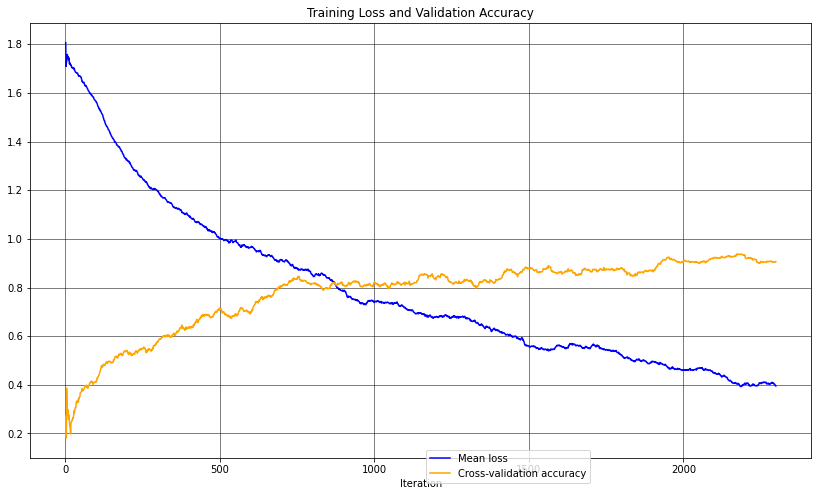

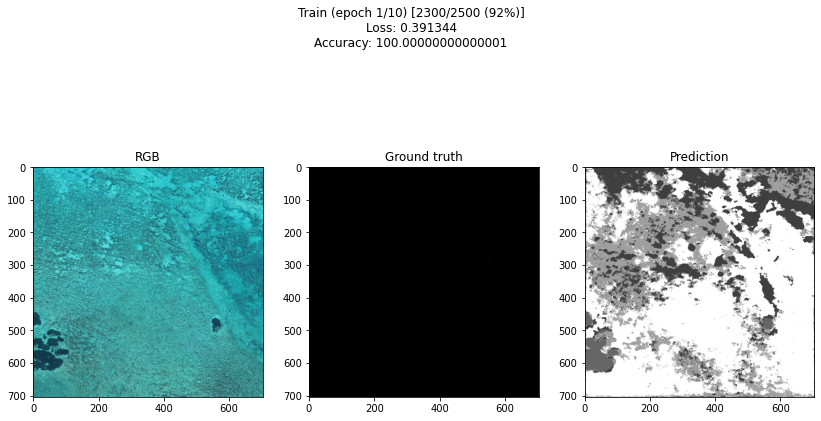

/tmp/ipykernel_3331876/2271824373.py:131: RuntimeWarning: invalid value encountered in double_scalars
  F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
/tmp/ipykernel_3331876/2271824373.py:131: RuntimeWarning: invalid value encountered in double_scalars
  F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
/tmp/ipykernel_3331876/2271824373.py:131: RuntimeWarning: invalid value encountered in double_scalars
  F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
/tmp/ipykernel_3331876/2271824373.py:131: RuntimeWarning: invalid value encountered in double_scalars
  F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
/tmp/ipykernel_3331876/2271824373.py:131: RuntimeWarning: invalid value encountered in double_scalars
  F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
/tmp/ipykernel_3331876/2271824373.py:131: RuntimeWarning: invalid value encountered in double_scalars
  F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm

In [ ]:
train(net, optimizer, 10, scheduler)


# Testing the network

Now that the training has ended, we can load the final weights and test the network using a reasonable stride, e.g. half or a quarter of the window size. Inference time depends on the chosen stride, e.g. a step size of 32 (75% overlap) will take 10 secondes / image.


In [ ]:
net.load_state_dict(torch.load('./model_final'))


In [ ]:
_, all_preds, all_gts = test(net, test_ids, all=True, stride=32)


# Saving the results

We can visualize and save the resulting tiles for qualitative assessment.


In [ ]:
for p, id_ in zip(all_preds, test_ids):
    img = convert_to_color(p)
    plt.imshow(img) and plt.show()
    io.imsave('/home/pagraf/Desktop/magicbathy/inference_tile_{}.png'.format(id_), img)
    #nlcd02_arr_1, nlcd02_ds_1 = read_geotiff(MAIN_FOLDER + 'puck_laggon/img/s2/img_3051.tif', 3)
    #write_geotiff('./inference_tile_{}.tif'.format(id_), img[1], nlcd02_ds_1)